<H3 align='center'> Challenge Kaggle - Predicción velocidad del viento </H3>
<hr style="height:2px;border:none"/>

**Integrantes:** \\

**Daniel Peralta**  -  201621053-9 \\
**Philip Guerra**   -  201623003-3

El desafío consiste en predecir la velocidad media del viento a 20 metros de altura en diferentes instantes de tiempo.

Se cargan los datos:

In [1]:
#
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#Para trabajar sobre imagenes
import cv2
import random
import os
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#datatime
import datetime as dt

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [2]:
#montamos google drive
from google.colab import drive

colab_flag = True

if (colab_flag):
    drive.mount('/content/drive')


path = '/content/drive/MyDrive/2021-1/Redes_neuronales_artificiales/Tarea3/'

Mounted at /content/drive


In [3]:
# se cargan los datos
data_train = pd.read_csv(path+'windspeed-training2.csv' ,header=1,engine='python')
print(data_train.shape)
data_train.head()

(123363, 2)


,2012-12-19 00:10,12.4
0,2012-12-19 00:20,11.4
1,2012-12-19 00:30,11.8
2,2012-12-19 00:40,11.6
3,2012-12-19 00:50,11.0
4,2012-12-19 01:00,11.5


Las principales ideas para el desafío son:


*   Trabajar los missing values de la serie de tiempo.
*   Visualizar la media y desviación estandar por hora y mes.
*   Probar una red LSTM con una función de costo MSE.
*   Explorar el comportamiento de una red GRU comparado con la LSTM. 
*   Comparar las redes recurrentes creadas con una clásica regresión lineal mediante mínimos cuadrados.



## Pre-procesamiento de datos

En primera instancia se grafica los datos a través del tiempo para observar su comportamiento.

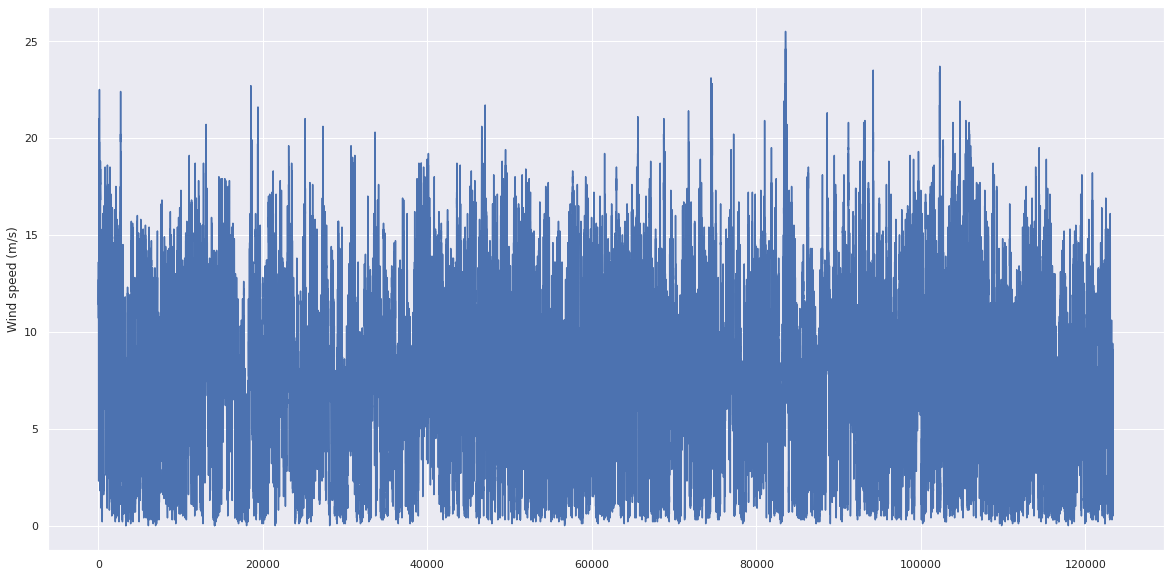

In [4]:

largo = data_train.shape[0]
x = np.zeros(largo)
plt.figure(figsize=(20, 10))
plt.plot(data_train['12.4'])
plt.ylabel('Wind speed (m/s)')
plt.show()

In [5]:
data_train.columns = ['Fecha', 'velocidad']
data_train

,Fecha,velocidad
0,2012-12-19 00:20,11.4
1,2012-12-19 00:30,11.8
2,2012-12-19 00:40,11.6
3,2012-12-19 00:50,11.0
4,2012-12-19 01:00,11.5
...,...,...
123358,2015-04-24 23:10,0.5
123359,2015-04-24 23:20,0.7
123360,2015-04-24 23:30,1.3
123361,2015-04-24 23:40,2.6


Se crea un nuevo data time desde la primera fecha del data_train hasta el último de este.

In [6]:
# date = dt.datetime.today() - dt.timedelta(days=1)
# date.month
date = dt.datetime(2012, 12, 19) + dt.timedelta(minutes=20)
super_date = pd.date_range(date, periods=(123363+43), freq='10min')
data_time = super_date.strftime("%Y-%m-%d %H:%M")
df = pd.DataFrame(data_time)
df.columns = ['Fecha']
df

,Fecha
0,2012-12-19 00:20
1,2012-12-19 00:30
2,2012-12-19 00:40
3,2012-12-19 00:50
4,2012-12-19 01:00
...,...
123401,2015-04-24 23:10
123402,2015-04-24 23:20
123403,2015-04-24 23:30
123404,2015-04-24 23:40


Al observar los dos conjuntos de datos, se tiene que hay diferencia en la cantidad de datos. Esto da a entender que hay *missing values*, los que habrá que buscar y completar con un valor.

In [7]:
lista_missing=[]  #estarán las fechas que faltan para el data_train
train_list = data_train.Fecha.to_list()
for k in df.Fecha:
  if k not in train_list:
    lista_missing.append(k)

In [8]:
lista_missing

['2014-01-09 16:50',
 '2014-01-09 17:00',
 '2014-01-09 17:10',
 '2014-01-09 17:20',
 '2014-01-09 17:30',
 '2014-01-09 17:40',
 '2014-01-09 17:50',
 '2014-01-09 18:00',
 '2014-01-09 18:10',
 '2014-01-09 18:20',
 '2014-01-09 18:30',
 '2014-01-09 18:40',
 '2014-01-09 18:50',
 '2014-01-09 19:00',
 '2014-01-09 19:10',
 '2014-01-09 19:20',
 '2014-01-09 19:30',
 '2014-01-09 19:40',
 '2014-01-09 19:50',
 '2014-01-09 20:00',
 '2014-01-09 20:10',
 '2014-01-09 20:20',
 '2014-01-09 20:30',
 '2014-01-09 20:40',
 '2014-01-09 20:50',
 '2014-01-09 21:00',
 '2014-01-09 21:10',
 '2014-01-09 21:20',
 '2014-01-09 21:30',
 '2014-01-09 21:40',
 '2014-01-09 21:50',
 '2014-01-09 22:00',
 '2014-01-09 22:10',
 '2014-01-09 22:20',
 '2014-01-09 22:30',
 '2014-01-09 22:40',
 '2014-01-09 22:50',
 '2014-01-09 23:00',
 '2014-01-09 23:10',
 '2014-01-09 23:20',
 '2014-01-09 23:30',
 '2014-01-09 23:40',
 '2014-01-09 23:50']

Para completar los *missing values* se considerará un promedio entre la velocidad del viento que había el día antes y el día después, tomando en cuenta la misma hora. Se crea una lista para el dia anterior y después con la misma hora:

In [9]:
date = dt.datetime(2014, 1, 8) + dt.timedelta(hours=16) + dt.timedelta(minutes=50)
super_date = pd.date_range(date, periods=(len(lista_missing)), freq='10min')
data_time_1 = super_date.strftime("%Y-%m-%d %H:%M")
df1 = pd.DataFrame(data_time_1)
df1.columns = ['Fecha']

date = dt.datetime(2014, 1, 10) + dt.timedelta(hours=16) + dt.timedelta(minutes=50)
super_date = pd.date_range(date, periods=(len(lista_missing)), freq='10min')
data_time_2 = super_date.strftime("%Y-%m-%d %H:%M")
df2 = pd.DataFrame(data_time_2)
df2.columns = ['Fecha']

In [10]:
df1.Fecha.to_list()

['2014-01-08 16:50',
 '2014-01-08 17:00',
 '2014-01-08 17:10',
 '2014-01-08 17:20',
 '2014-01-08 17:30',
 '2014-01-08 17:40',
 '2014-01-08 17:50',
 '2014-01-08 18:00',
 '2014-01-08 18:10',
 '2014-01-08 18:20',
 '2014-01-08 18:30',
 '2014-01-08 18:40',
 '2014-01-08 18:50',
 '2014-01-08 19:00',
 '2014-01-08 19:10',
 '2014-01-08 19:20',
 '2014-01-08 19:30',
 '2014-01-08 19:40',
 '2014-01-08 19:50',
 '2014-01-08 20:00',
 '2014-01-08 20:10',
 '2014-01-08 20:20',
 '2014-01-08 20:30',
 '2014-01-08 20:40',
 '2014-01-08 20:50',
 '2014-01-08 21:00',
 '2014-01-08 21:10',
 '2014-01-08 21:20',
 '2014-01-08 21:30',
 '2014-01-08 21:40',
 '2014-01-08 21:50',
 '2014-01-08 22:00',
 '2014-01-08 22:10',
 '2014-01-08 22:20',
 '2014-01-08 22:30',
 '2014-01-08 22:40',
 '2014-01-08 22:50',
 '2014-01-08 23:00',
 '2014-01-08 23:10',
 '2014-01-08 23:20',
 '2014-01-08 23:30',
 '2014-01-08 23:40',
 '2014-01-08 23:50']

In [11]:
#creamos un diccionario del data_train
res = {data_train.Fecha[i]: data_train.velocidad[i] for i in range(len(data_train))}

Se agregan los *missing values* como el promedio del valor del día anterior y posterior para la misma hora.

In [12]:
#data_viento = np.zeros(len(df))
data_viento=[]
for i in range(len(df)):
    if df.Fecha[i] in train_list:
      data_viento.append(res[df.Fecha[i]])
    else:
      if df.Fecha[i][8:10] == '09':
        day_b = df.Fecha[i][0:8]+'0' + str(int(df.Fecha[i][8:10])-1) + df.Fecha[i][10:]
        day_a = df.Fecha[i][0:8]+ str(int(df.Fecha[i][8:10])+1) + df.Fecha[i][10:]
        promedio = (res[day_b] + res[day_a])/2
        data_viento.append(promedio)
      else:
        day_b = df.Fecha[i][0:8]+ '0'+ str(int(df.Fecha[i][8:10])-1) + df.Fecha[i][10:]
        day_a = df.Fecha[i][0:8]+ '0'+ str(int(df.Fecha[i][8:10])+1) + df.Fecha[i][10:]
        promedio = (res[day_b] + res[day_a])/2
        data_viento.append(promedio)

In [13]:
len(df), len(data_viento)

(123406, 123406)

In [14]:
df.insert(1,'velocidad',data_viento,True)

In [15]:
#el dataset con los missing values con valores
df

,Fecha,velocidad
0,2012-12-19 00:20,11.4
1,2012-12-19 00:30,11.8
2,2012-12-19 00:40,11.6
3,2012-12-19 00:50,11.0
4,2012-12-19 01:00,11.5
...,...,...
123401,2015-04-24 23:10,0.5
123402,2015-04-24 23:20,0.7
123403,2015-04-24 23:30,1.3
123404,2015-04-24 23:40,2.6


### Análisis por mes

Se analiza la media y desviación estándar de los datos.

In [27]:
enero=[];febrero=[];marzo=[];abril=[];mayo=[];junio=[]
julio=[];agosto=[];septiembre=[];octubre=[];noviembre=[];diciembre=[]

In [30]:
for k in range(len(df)):
      mes = df.Fecha[k][5:7]
      viento = df.velocidad[k] 
      if mes == '01':
        enero.append(viento)
      if mes == '02':
        febrero.append(viento)
      if mes == '03':
        marzo.append(viento)
      if mes == '04':
        abril.append(viento)
      if mes == '05':
        mayo.append(viento)
      if mes == '06':
        junio.append(viento)
      if mes == '07':
        julio.append(viento)
      if mes == '08':
        agosto.append(viento)
      if mes == '09':
        septiembre.append(viento)
      if mes == '10':
        octubre.append(viento)
      if mes == '11':
        noviembre.append(viento)
      else:
        diciembre.append(viento)
          

In [33]:
np.array(diciembre).mean()

7.621381768119478

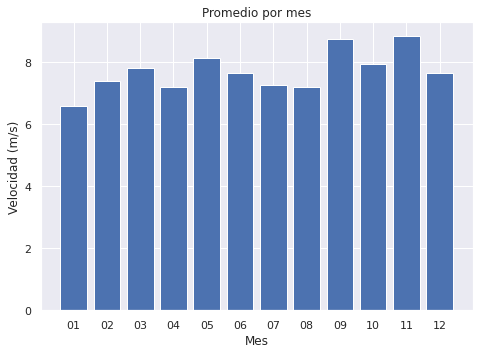

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
meses = ['01', '02', '03', '04', '05','06', '07', '08', '09', '10', '11', '12']
promedio = [np.array(enero).mean(), np.array(febrero).mean(), np.array(marzo).mean(), np.array(abril).mean(), np.array(mayo).mean(),np.array(junio).mean(),np.array(julio).mean(),np.array(agosto).mean(),np.array(septiembre).mean(),np.array(octubre).mean(),np.array(noviembre).mean(),np.array(diciembre).mean()]
desvi = [np.array(enero).std(), np.array(febrero).std(), np.array(marzo).std(), np.array(abril).std(), np.array(mayo).std(),np.array(junio).std(),np.array(julio).std(),np.array(agosto).std(),np.array(septiembre).std(),np.array(octubre).std(),np.array(noviembre).std(),np.array(diciembre).std()]
ax.bar(meses,promedio)
ax.set_title("Promedio por mes")
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("Velocidad (m/s)", fontsize=12)
plt.show()

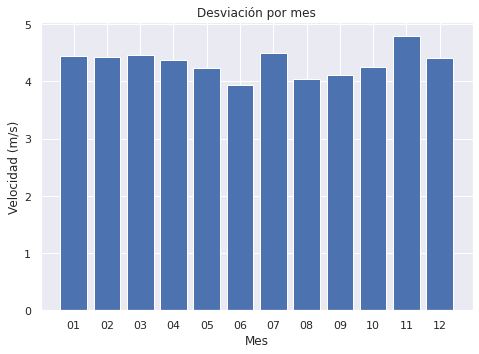

In [43]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(meses,desvi)
ax.set_title("Desviación por mes")
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("Velocidad (m/s)", fontsize=12)
plt.show()

### Análisis por hora

In [53]:
hora1=[];hora2=[];hora3=[];hora4=[];hora4=[];hora5=[];hora6=[];
hora7=[];hora8=[];hora9=[];hora10=[];hora11=[];hora12=[]
hora13=[];hora14=[];hora15=[];hora16=[];hora17=[];hora18=[]
hora19=[];hora20=[];hora21=[];hora22=[];hora23=[];hora24=[]

In [54]:
for k in range(len(df)):
      hora = df.Fecha[k][11:13]
      viento = df.velocidad[k] 
      if hora == '01':
        hora1.append(viento)
      if hora == '02':
        hora2.append(viento)
      if hora == '03':
        hora3.append(viento)
      if hora == '04':
        hora4.append(viento)
      if hora == '05':
        hora5.append(viento)
      if hora == '06':
        hora6.append(viento)
      if hora == '07':
        hora7.append(viento)
      if hora == '08':
        hora8.append(viento)
      if hora == '09':
        hora9.append(viento)
      if hora == '10':
        hora10.append(viento)
      if hora == '11':
        hora11.append(viento)
      if hora == '12':
        hora12.append(viento)
      if hora == '13':
        hora13.append(viento)
      if hora == '14':
        hora14.append(viento)
      if hora == '15':
        hora15.append(viento)
      if hora == '16':
        hora16.append(viento)
      if hora == '17':
        hora17.append(viento)
      if hora == '18':
        hora18.append(viento)
      if hora == '19':
        hora19.append(viento)
      if hora == '20':
        hora20.append(viento)
      if hora == '21':
        hora21.append(viento)
      if hora == '22':
        hora22.append(viento)
      if hora == '23':
        hora23.append(viento)
      else:
        hora24.append(viento)

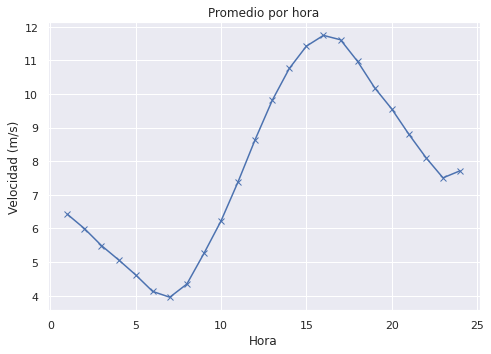

In [62]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
hora = list(range(1, 25))
promedio = [np.array(hora1).mean(), np.array(hora2).mean(), np.array(hora3).mean(), np.array(hora4).mean(), np.array(hora5).mean(),np.array(hora6).mean(),np.array(hora7).mean(),np.array(hora8).mean(),np.array(hora9).mean(),np.array(hora10).mean(),np.array(hora11).mean(),np.array(hora12).mean(),np.array(hora13).mean(), np.array(hora14).mean(), np.array(hora15).mean(), np.array(hora16).mean(), np.array(hora17).mean(),np.array(hora18).mean(),np.array(hora19).mean(),np.array(hora20).mean(),np.array(hora21).mean(),np.array(hora22).mean(),np.array(hora23).mean(),np.array(hora24).mean()]
desvi = [np.array(hora1).std(), np.array(hora2).std(), np.array(hora3).std(), np.array(hora4).std(), np.array(hora5).std(),np.array(hora6).std(),np.array(hora7).std(),np.array(hora8).std(),np.array(hora9).std(),np.array(hora10).std(),np.array(hora11).std(),np.array(hora12).std(),np.array(hora13).std(), np.array(hora14).std(), np.array(hora15).std(), np.array(hora16).std(), np.array(hora17).std(),np.array(hora18).std(),np.array(hora19).std(),np.array(hora20).std(),np.array(hora21).std(),np.array(hora22).std(),np.array(hora23).std(),np.array(hora24).std()]
#desvi = [np.array(enero).std(), np.array(febrero).std(), np.array(marzo).std(), np.array(abril).std(), np.array(mayo).std(),np.array(junio).std(),np.array(julio).std(),np.array(agosto).std(),np.array(septiembre).std(),np.array(octubre).std(),np.array(noviembre).std(),np.array(diciembre).std()]
plt.plot(hora, promedio, marker='x')
plt.xlabel('Hora')
plt.ylabel('Velocidad (m/s)')
plt.title('Promedio por hora')
plt.show()


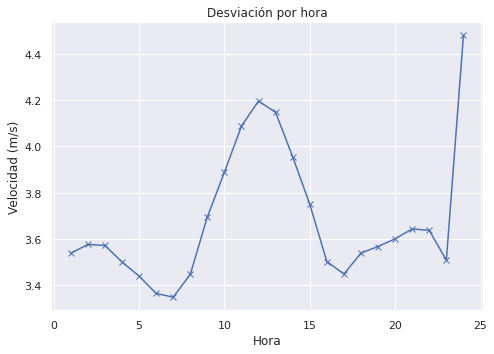

In [63]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.plot(hora, desvi, marker='x')
plt.xlabel('Hora')
plt.ylabel('Velocidad (m/s)')
plt.title('Desviación por hora')
plt.show()

De las gráficas tanto por mes como por hora, se observa hay una diferncia de magnitud entre la hora y mes respectivo. Por ejemplo, de los meses de septiembre a noviembre se observa un alza en los valores promedio de la velocidad del viento. En tanto para el análisis horario, de las 15:00 a las 17:00 hrs se observa los valores máximos de viento. De este análisis se puede concluir que indicarle a la red el mes o la hora podría ayudar a realizar una mejor predicción. 

Se crean los dataset de *training* y *validation*, tomando el 20% inicial para validación y el resto para entrenamiento. Es importante considerar que los conjuntos serán sucesivos ya que en este tipo de redes importa el orden. 

In [16]:
data_val, data_tr = [df.velocidad[int(df.velocidad.shape[0]*k1):int(df.velocidad.shape[0]*k2)].to_numpy().reshape(-1,1) for k1, k2 in [[0.00, 0.20], [0.20, 1.0]]]
time_val, time_tr = [df.Fecha[int(df.Fecha.shape[0]*k1):int(df.Fecha.shape[0]*k2)] for k1, k2 in [[0.00, 0.20], [0.20, 1.0]]]

## Red LSTM

Como primera red se propondrá una LSTM. Para la predicción de cada *timestep* nuevo se tomará en cuenta 144 tiempos anteriores (144 datos porque considerando que el delta de tiempo es de 10 minutos, un día equivale a 144 *steps*). Para esto se hará uso de la función *split_sequence()*.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_tr) # Se establece como conjunto base la muestra original
data_tr2, data_val2 = [scaler.transform(k) for k in [data_tr, data_val]]

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y , seq_t= list(), list(), list()
    for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(sequence):    
          break
      #print(sequence)
      #print(i)    
      # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix, 0]
      # print(i) 
      # seq_t.append(time_seq[end_ix])
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y) , np.asarray(seq_t)

In [ ]:
len_inp, len_out = 144, 1
x_tr,  y_tr,  t_tr  = split_sequence(data_tr2,  len_inp, len_out)
x_val, y_val, t_val = split_sequence(data_val2, len_inp, len_out)

In [ ]:
x_tr.shape, y_tr.shape

((98581, 144, 1), (98581, 1))



*   98581: Número de muestras.
*   144: steps de tiempo para un día cada 10 minutos.
*   1: dato (viento).



Se procede a crear la red LSTM. 

In [ ]:
import tensorflow as tf
import time
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer
tf.random.set_seed(12345)
epochs = 2
t0=time.time() 

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm)
rnn=layers.LSTM(units=56,return_sequences=False)(rnn)
dens=layers.Dense(len_out, activation='linear')(rnn)
model_1=models.Model(inputs=input_lstm, outputs=dens)
model_1.compile(loss='mse', optimizer='adam', metrics=['mse'])
history_1   = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=epochs, batch_size=16, verbose=1)
#test_loss_1 = tf.math.reduce_mean(tf.keras.losses.MSE(model_1(x_tst[:,:,0:1]), y_tst))
#print(r"Training Time: %s ~ %.4fs" % tuple([str(datetime.fromtimestamp(time.time()-t0).strftime("%X")), time.time()-t0]))
#print(r'Test Loss: %.4f'%(test_loss_1))

Epoch 1/2
6162/6162 [==============================] - 1709s 277ms/step - loss: 0.0620 - acc: 0.0000e+00 - val_loss: 0.0512 - val_acc: 0.0000e+00
Epoch 2/2
6162/6162 [==============================] - 1710s 277ms/step - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0486 - val_acc: 0.0000e+00


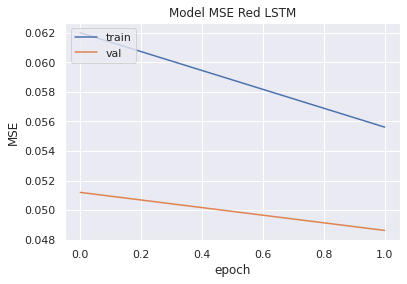

In [ ]:
plt.plot(history_1.history['mse'])
plt.plot(history_1.history['val_mse'])
plt.title('Model MSE Red LSTM')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Red GRU

Una red GRU posee una arquitectura más simplificada que la LSTM al contener una compuerta menos. Se construye la red con la misma arquitectura para poder compararlas.

In [ ]:
import tensorflow as tf
import time
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer
tf.random.set_seed(12345)
epochs = 2
t0=time.time() 

#print('Model 1: Univariante')
input_gru= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.GRU(units=56,return_sequences=True)(input_gru)
rnn=layers.GRU(units=56,return_sequences=False)(rnn)
dens=layers.Dense(len_out, activation='linear')(rnn)
model_2=models.Model(inputs=input_gru, outputs=dens)
model_2.compile(loss='mse', optimizer='adam', metrics=['mse'])
history_2   = model_2.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=epochs, batch_size=16, verbose=1)

Epoch 1/2
6162/6162 [==============================] - 1625s 263ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 2/2
6162/6162 [==============================] - 1605s 260ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0491 - val_mse: 0.0491


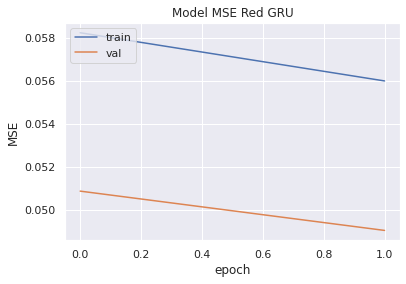

In [ ]:
plt.plot(history_2.history['mse'])
plt.plot(history_2.history['val_mse'])
plt.title('Model MSE Red GRU')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Comparando los valores de loss de ambas redes, se observa un comportamiento similar, llegando a valores cercanos. Se realizaron solo dos iteraciones debido al tiempo que demoraba. Se procederá a probar la red LSTM debido a que su valor de loss es un poco menor que la GRU.

Para testear la red, se estimará el valor del viento desde la última fecha del *data train* hasta la última fecha del test. 

Se genera un data frame que parta de 2015-04-25 00:00 hasta 2015-09-24 23:50 con un delta de tiempo de 10 minutos. Se crea esto porque para generar la predicción para cierto *timestep* se necesita los 144 anteriores.

In [ ]:
numero = 22032
date = dt.datetime(2015, 4, 25)
super_date = pd.date_range(date, periods=(numero), freq='10min')
data_time = super_date.strftime("%Y-%m-%d %H:%M")
df3 = pd.DataFrame(data_time)
df3.columns = ['Fecha']
df3

,Fecha
0,2015-04-25 00:00
1,2015-04-25 00:10
2,2015-04-25 00:20
3,2015-04-25 00:30
4,2015-04-25 00:40
...,...
22027,2015-09-24 23:10
22028,2015-09-24 23:20
22029,2015-09-24 23:30
22030,2015-09-24 23:40


In [ ]:
aux3 = pd.to_datetime(df3.Fecha).astype(int)/(1e9)

Se crea una lista (vamos) que tendrá los datos de predicción de la red neuronal.

In [ ]:
delta = len(df3)
vamos = np.ones([delta,1])
#vamos[0:144] = X_0
for k in range(delta-1):
  z = model_1.predict(vamos[0+k:144+k].reshape(1,144,1))
  vamos[144+k]=z

IndexError: ignored

In [ ]:
vamos.shape
vamos_wanderers = scaler.inverse_transform(vamos)
vamos_wanderers

array([[12.1340759 ],
       [12.1340759 ],
       [12.1340759 ],
       ...,
       [ 9.40897023],
       [ 9.40897023],
       [ 9.4089701 ]])

Se crea un *data frame* con la fecha y la predicción de velocidad. 

In [ ]:
df3.insert(1,'velocidad',vamos_wanderers,True)
df3

,Fecha,velocidad
0,2015-04-25 00:00,12.134076
1,2015-04-25 00:10,12.134076
2,2015-04-25 00:20,12.134076
3,2015-04-25 00:30,12.134076
4,2015-04-25 00:40,12.134076
...,...,...
22027,2015-09-24 23:10,9.408970
22028,2015-09-24 23:20,9.408970
22029,2015-09-24 23:30,9.408970
22030,2015-09-24 23:40,9.408970


Se cargan los datos a testear.

In [ ]:
data_test = pd.read_csv(path + 'windspeed-testing.csv' ,header=None,engine='python')
data_test.columns = ['Fecha']
print(data_test.shape)
data_test.head()

(2000, 1)


,Fecha
0,26-04-2015 01:50
1,26-04-2015 03:10
2,26-04-2015 04:20
3,26-04-2015 05:20
4,26-04-2015 06:40


In [ ]:
fecha2 = []
for k in range(len(data_test.Fecha)):
  dia = data_test.Fecha[k][8:10]
  mes = data_test.Fecha[k][5:7]
  año = data_test.Fecha[k][0:4]
  hora = data_test.Fecha[k][11:]
  n_dia = dia+'-'+mes+'-'+año+' '+hora
  fecha2.append(n_dia)
data_test.insert(1,'Fecha2',fecha2,True)
data_test

,Fecha,Fecha2
0,26-04-2015 01:50,15--2-26-0 01:50
1,26-04-2015 03:10,15--2-26-0 03:10
2,26-04-2015 04:20,15--2-26-0 04:20
3,26-04-2015 05:20,15--2-26-0 05:20
4,26-04-2015 06:40,15--2-26-0 06:40
...,...,...
1995,19-09-2015 08:10,15--2-19-0 08:10
1996,21-09-2015 11:20,15--2-21-0 11:20
1997,22-09-2015 10:30,15--2-22-0 10:30
1998,23-09-2015 17:30,15--2-23-0 17:30


In [ ]:
#fechas al reves
fecha2 = []
for k in range(len(df3.Fecha)):
  dia = df3.Fecha[k][8:10]
  mes = df3.Fecha[k][5:7]
  año = df3.Fecha[k][0:4]
  hora = df3.Fecha[k][11:]
  n_dia = dia+'-'+mes+'-'+año+' '+hora
  fecha2.append(n_dia)
df3.insert(2,'Fecha2',fecha2,True)
df3

,Fecha,velocidad,Fecha2
0,2015-04-25 00:00,12.134076,25-04-2015 00:00
1,2015-04-25 00:10,12.134076,25-04-2015 00:10
2,2015-04-25 00:20,12.134076,25-04-2015 00:20
3,2015-04-25 00:30,12.134076,25-04-2015 00:30
4,2015-04-25 00:40,12.134076,25-04-2015 00:40
...,...,...,...
22027,2015-09-24 23:10,9.408970,24-09-2015 23:10
22028,2015-09-24 23:20,9.408970,24-09-2015 23:20
22029,2015-09-24 23:30,9.408970,24-09-2015 23:30
22030,2015-09-24 23:40,9.408970,24-09-2015 23:40


In [ ]:
#creamos un diccionario
res2={}
res2 = {df3.Fecha2[i]: df3.velocidad[i] for i in range(len(df3))}

Se añade a los testeos los vientos. 

In [ ]:
ahora_si=[]
for k in data_test.Fecha:
	vel = res2[k]
	ahora_si.append(vel)
	
data_test.insert(1,'viento',ahora_si,True)
data_test

,Fecha,viento,Fecha2
0,26-04-2015 01:50,11.156578,15--2-26-0 01:50
1,26-04-2015 03:10,10.620681,15--2-26-0 03:10
2,26-04-2015 04:20,10.220370,15--2-26-0 04:20
3,26-04-2015 05:20,9.940079,15--2-26-0 05:20
4,26-04-2015 06:40,9.657193,15--2-26-0 06:40
...,...,...,...
1995,19-09-2015 08:10,9.408970,15--2-19-0 08:10
1996,21-09-2015 11:20,9.408971,15--2-21-0 11:20
1997,22-09-2015 10:30,9.408971,15--2-22-0 10:30
1998,23-09-2015 17:30,9.408970,15--2-23-0 17:30


In [ ]:
new = data_test[['Fecha','viento']].copy()
new.to_csv('data.csv',index=False)
!cp data.csv "drive/My Drive/

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
vamos

array([[-1.2141892 ],
       [-1.2141892 ],
       [-1.07909634],
       ...,
       [-0.55205774],
       [-0.55205774],
       [-0.55205774]])

Se hace un gráfico de dos días posterior al último dato de entrenamiento.

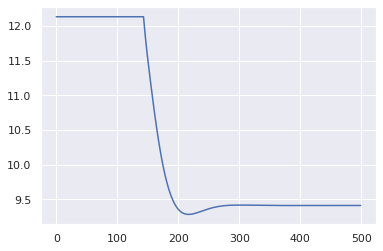

In [ ]:
#vamos[0:144]
#vamos_wanderers = scaler.inverse_transform(vamos)
# plt.plot(np.linspace(0,144,144),vamos_wanderers[0:144])
# plt.plot(np.linspace(0+144,144+144,144),vamos_wanderers[144:288])
plt.plot(vamos_wanderers[0:500])

Se observa que a medida que pasan los timesteps se estaciona en un valor la predicción. Esto ocurre debido a que se crea un efecto avalancha en la red debido a la cantidad de secuencias que se usa en el entrenamiento. 

## Regresión lineal

Por último, se emplea una regresión lineal con los datos. Presenta la ventaja de ser muy simple de implementar y para realizarla se utiliza MSE.

In [ ]:
aux_tr = pd.to_datetime(time_tr).astype(int)/(1e9) 
aux_val = pd.to_datetime(time_val).astype(int)/(1e9)

In [ ]:
data_tr.shape, aux_tr.shape

((98725, 1), (98725,))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(aux_tr.to_numpy().reshape(-1,1))
x_test = scaler.transform(aux_val.to_numpy().reshape(-1,1))

In [ ]:
y_train = data_tr
y_test = data_val
from sklearn.linear_model import LinearRegression
from sklearn import metrics
model = LinearRegression().fit(x_train,y_train)
print(model.score(x_train,y_train))
y_pred =model.predict(x_test)

0.0005699674589897397


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 3.7546228604817973
MSE: 19.880854807421063
RMSE: 4.458795219274043


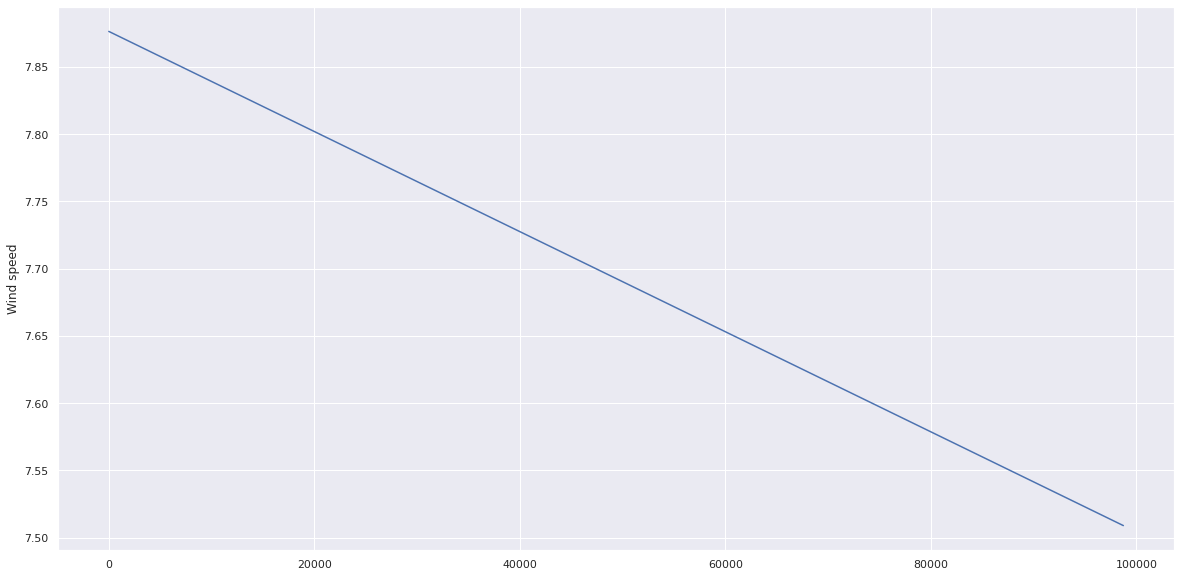

In [ ]:
y_pred2 =model.predict(x_train)
pred2 = pd.DataFrame(y_pred2)
largo = data_train.shape[0]
x = np.zeros(largo)
plt.figure(figsize=(20, 10))
plt.plot(pred2)
plt.ylabel('Wind speed')
plt.show()

In [ ]:
data_test = pd.read_csv(path + 'windspeed-testing.csv' ,header=None,engine='python')
print(data_test.shape)
data_test.head()
aux2 = pd.to_datetime(data_test[0]).astype(int)/(1e9)
# valor_1 = aux2.iloc[-1]

(2000, 1)


In [ ]:
x_test2 = scaler.transform(aux_val.to_numpy().reshape(-1,1))
y_pred3 =model.predict(x_test2)

pred3 = pd.DataFrame(y_pred3)

In [ ]:
pred3.shape, aux2.shape

((24681, 1), (2000,))

In [ ]:
data_test

,0
0,26-04-2015 01:50
1,26-04-2015 03:10
2,26-04-2015 04:20
3,26-04-2015 05:20
4,26-04-2015 06:40
...,...
1995,19-09-2015 08:10
1996,21-09-2015 11:20
1997,22-09-2015 10:30
1998,23-09-2015 17:30


In [ ]:
numero = 21381+350+4
date = dt.datetime(2015, 4, 26) + dt.timedelta(minutes=50) + dt.timedelta(hours=1)
super_date = pd.date_range(date, periods=(numero), freq='10min')
data_time = super_date.strftime("%Y-%m-%d %H:%M")
df2 = pd.DataFrame(data_time)
df2.columns = ['Fecha']
df2

,Fecha
0,2015-04-26 01:50
1,2015-04-26 02:00
2,2015-04-26 02:10
3,2015-04-26 02:20
4,2015-04-26 02:30
...,...
21730,2015-09-23 23:30
21731,2015-09-23 23:40
21732,2015-09-23 23:50
21733,2015-09-24 00:00


In [ ]:
fecha2 = []
for k in range(len(df2.Fecha)):
  dia = df2.Fecha[k][8:10]
  mes = df2.Fecha[k][5:7]
  año = df2.Fecha[k][0:4]
  hora = df2.Fecha[k][11:]
  n_dia = dia+'-'+mes+'-'+año+' '+hora
  fecha2.append(n_dia)
df2.insert(1,'Fecha2',fecha2,True)
df2

,Fecha,Fecha2
0,2015-04-26 01:50,26-04-2015 01:50
1,2015-04-26 02:00,26-04-2015 02:00
2,2015-04-26 02:10,26-04-2015 02:10
3,2015-04-26 02:20,26-04-2015 02:20
4,2015-04-26 02:30,26-04-2015 02:30
...,...,...
21730,2015-09-23 23:30,23-09-2015 23:30
21731,2015-09-23 23:40,23-09-2015 23:40
21732,2015-09-23 23:50,23-09-2015 23:50
21733,2015-09-24 00:00,24-09-2015 00:00


In [ ]:
data_test.insert(1,'Fecha_num',aux2,True)
data_test

,0,Fecha_num
0,26-04-2015 01:50,1.430013e+09
1,26-04-2015 03:10,1.430018e+09
2,26-04-2015 04:20,1.430022e+09
3,26-04-2015 05:20,1.430026e+09
4,26-04-2015 06:40,1.430030e+09
...,...,...
1995,19-09-2015 08:10,1.442650e+09
1996,21-09-2015 11:20,1.442834e+09
1997,22-09-2015 10:30,1.442918e+09
1998,23-09-2015 17:30,1.443029e+09


In [ ]:
x_test_final = scaler.transform(aux2.to_numpy().reshape(-1,1))

In [ ]:
prediccion =model.predict(x_test_final)

In [ ]:
data_test.insert(2,'viento',prediccion,True)
data_test

,0,Fecha_num,viento
0,26-04-2015 01:50,1.430013e+09,7.508452
1,26-04-2015 03:10,1.430018e+09,7.508423
2,26-04-2015 04:20,1.430022e+09,7.508397
3,26-04-2015 05:20,1.430026e+09,7.508374
4,26-04-2015 06:40,1.430030e+09,7.508345
...,...,...,...
1995,19-09-2015 08:10,1.442650e+09,7.430090
1996,21-09-2015 11:20,1.442834e+09,7.428948
1997,22-09-2015 10:30,1.442918e+09,7.428431
1998,23-09-2015 17:30,1.443029e+09,7.427739


In [ ]:
new = data_test[[0,'viento']].copy()

In [ ]:
new

,0,viento
0,26-04-2015 01:50,7.508452
1,26-04-2015 03:10,7.508423
2,26-04-2015 04:20,7.508397
3,26-04-2015 05:20,7.508374
4,26-04-2015 06:40,7.508345
...,...,...
1995,19-09-2015 08:10,7.430090
1996,21-09-2015 11:20,7.428948
1997,22-09-2015 10:30,7.428431
1998,23-09-2015 17:30,7.427739


In [ ]:
new.to_csv('data.csv',index=False)
!cp data.csv "drive/My Drive/"

# Conclusiones

Al realizar los submission en la página del desafío kaggle, se obtuvo que la regresión lineal obtuvo un desempeño mejor que la red LSTM, por una pequeña diferencia. El resultado es interesante debido a la simplicidad que resulta una regresión lineal y el poco tiempo que demora en crearse, en constraste del largo tiempo que se debe invertir en entrenar una red recurrente. Además, se observa que la red creada converge a un valor, lo que da a entender que se produce explosión de gradiente y la red deja de aprender.

Opciones interesantes de investigar puede haber sido aumentar la profundidad de las redes neuronales, aunque esto requiera un tiempo considerable. A su vez, se podrían haber añadido más parámetros a la entrada, como la media del viento en el mes u hora correspondiente, de esta forma, la red hubiera contado con más contexto para realizar la predicción.